# Second trial with simple MLP

In [51]:
# Import general libraries here.
import os
import glob
from tqdm import tqdm

import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [52]:
# Directory names.
DATA_DIR = "D:\\Programming\\20220712_titanic\\kaggle-titanic\\data\\titanic"
SRC_DIR = "D:\\Programming\\20220712_titanic\\kaggle-titanic\\src"
RESULT_DIR = "D:\\Programming\\20220712_titanic\\kaggle-titanic\\result\\20220712_nb01"

## Load titanic data

In [53]:
train_data = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [54]:
test_data = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Define simple MLP

In [55]:
class Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.fc1 = nn.Linear(self.in_dim, 100)
        self.fc2 = nn.Linear(100, out_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [56]:
#print(torch.cuda.is_available())
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
#test_in = torch.zeros((1, 5)).to("cuda:0")
#model = Net(5, 1).cuda()
#test_out = model(test_in)
#print(test_out)

## Trainer

In [57]:
# Definition of dataset.

from torch.utils.data import Dataset, DataLoader

class TitanicDataset(Dataset):
    def __init__(self, data_df, train):
        self.data_df = data_df
        self.train = train
        self.features = ["Pclass", "Sex", "SibSp", "Parch"]
        if self.train:
            self.labels = self.data_df["Survived"].values
        self.inputs = pd.get_dummies(self.data_df[self.features]).values
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        in_feat = self.inputs[idx]
        in_feat = torch.from_numpy(in_feat).float()
        if self.train:
            label = self.labels[idx]
            #label = torch.from_numpy(label)
            label = torch.tensor(label).float()
            return in_feat, label
        return in_feat

In [58]:
# Setup training environments.

# Device setting
device = "cuda" if torch.cuda.is_available() else "cpu"
n_epochs = 100
learning_rate = 1e-3
average_loss_list = list()

# Dataloaders.
train_dataset = TitanicDataset(train_data, train=True)
test_dataset = TitanicDataset(test_data, train=False)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

# Model definition.
model = Net(5, 1).to(device)
#model = Net(5, 1)
model = model.train()

# Optimizer / Loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction="mean")

for epoch in range(n_epochs):
    loss_sum = 0
    for in_feat, label in tqdm(train_loader):
        in_feat = in_feat.to(device)
        label = label.to(device)
        #print(in_feat)
        #print(label)

        optimizer.zero_grad()

        output = model(in_feat)
        output = output[:, 0]
        loss = criterion(output, label)
        loss_sum += loss.item()

        loss.backward()
        optimizer.step()
    average_loss_list.append(loss_sum / len(train_loader))
    print(f"Epoch : {epoch} / {n_epochs} | Loss average : {loss_sum / len(train_loader)}")
    torch.save(model.state_dict(), os.path.join(RESULT_DIR, "model-best.pt"))

#loss_sum = 0
predictions = list()
with torch.no_grad():
    for in_feat in tqdm(test_loader):
        in_feat = in_feat.to(device)
        output = model(in_feat)
        output = output[:, 0]
        prediction = torch.where(output >= 0.5, 1, 0).detach().cpu().numpy()
        predictions.extend(prediction)

output = pd.DataFrame({
    "PassengerId": test_data.PassengerId,
    "Survived": predictions
})
output_file = os.path.join(RESULT_DIR, "submission.csv")
output.to_csv(output_file, index=False)
print(f"Saved submission csv file as: {output_file}")

100%|██████████| 18/18 [00:00<00:00, 580.68it/s]


Epoch : 0 / 100 | Loss average : 0.6390847927994199


100%|██████████| 18/18 [00:00<00:00, 505.90it/s]


Epoch : 1 / 100 | Loss average : 0.5854637192355262


100%|██████████| 18/18 [00:00<00:00, 473.67it/s]


Epoch : 2 / 100 | Loss average : 0.5539338290691376


100%|██████████| 18/18 [00:00<00:00, 418.63it/s]


Epoch : 3 / 100 | Loss average : 0.527900743815634


100%|██████████| 18/18 [00:00<00:00, 409.10it/s]


Epoch : 4 / 100 | Loss average : 0.510629673798879


100%|██████████| 18/18 [00:00<00:00, 460.98it/s]


Epoch : 5 / 100 | Loss average : 0.49736655089590287


100%|██████████| 18/18 [00:00<00:00, 400.01it/s]


Epoch : 6 / 100 | Loss average : 0.4845028618971507


100%|██████████| 18/18 [00:00<00:00, 418.62it/s]


Epoch : 7 / 100 | Loss average : 0.47709884411758846


100%|██████████| 18/18 [00:00<00:00, 428.59it/s]


Epoch : 8 / 100 | Loss average : 0.47211843232313794


100%|██████████| 18/18 [00:00<00:00, 418.62it/s]


Epoch : 9 / 100 | Loss average : 0.4661810315317578


100%|██████████| 18/18 [00:00<00:00, 428.60it/s]


Epoch : 10 / 100 | Loss average : 0.4633328699403339


100%|██████████| 18/18 [00:00<00:00, 428.59it/s]


Epoch : 11 / 100 | Loss average : 0.4603963709539837


100%|██████████| 18/18 [00:00<00:00, 418.63it/s]


Epoch : 12 / 100 | Loss average : 0.4584108177158568


100%|██████████| 18/18 [00:00<00:00, 418.63it/s]


Epoch : 13 / 100 | Loss average : 0.4562828673256768


100%|██████████| 18/18 [00:00<00:00, 439.01it/s]


Epoch : 14 / 100 | Loss average : 0.453607064154413


100%|██████████| 18/18 [00:00<00:00, 449.97it/s]


Epoch : 15 / 100 | Loss average : 0.451781314280298


100%|██████████| 18/18 [00:00<00:00, 465.99it/s]


Epoch : 16 / 100 | Loss average : 0.4518943594561683


100%|██████████| 18/18 [00:00<00:00, 461.56it/s]


Epoch : 17 / 100 | Loss average : 0.4511948294109768


100%|██████████| 18/18 [00:00<00:00, 439.00it/s]


Epoch : 18 / 100 | Loss average : 0.4501553045378791


100%|██████████| 18/18 [00:00<00:00, 418.63it/s]


Epoch : 19 / 100 | Loss average : 0.44934318131870693


100%|██████████| 18/18 [00:00<00:00, 418.63it/s]


Epoch : 20 / 100 | Loss average : 0.4478004326423009


100%|██████████| 18/18 [00:00<00:00, 486.49it/s]


Epoch : 21 / 100 | Loss average : 0.4462950709793303


100%|██████████| 18/18 [00:00<00:00, 472.45it/s]


Epoch : 22 / 100 | Loss average : 0.4459501753250758


100%|██████████| 18/18 [00:00<00:00, 620.77it/s]


Epoch : 23 / 100 | Loss average : 0.44517697559462654


100%|██████████| 18/18 [00:00<00:00, 666.69it/s]


Epoch : 24 / 100 | Loss average : 0.4428664445877075


100%|██████████| 18/18 [00:00<00:00, 473.47it/s]


Epoch : 25 / 100 | Loss average : 0.4431314369042714


100%|██████████| 18/18 [00:00<00:00, 439.03it/s]


Epoch : 26 / 100 | Loss average : 0.44219427473015255


100%|██████████| 18/18 [00:00<00:00, 450.04it/s]


Epoch : 27 / 100 | Loss average : 0.443395475546519


100%|██████████| 18/18 [00:00<00:00, 439.05it/s]


Epoch : 28 / 100 | Loss average : 0.4450988521178563


100%|██████████| 18/18 [00:00<00:00, 439.04it/s]


Epoch : 29 / 100 | Loss average : 0.4409633262289895


100%|██████████| 18/18 [00:00<00:00, 461.56it/s]


Epoch : 30 / 100 | Loss average : 0.43998685479164124


100%|██████████| 18/18 [00:00<00:00, 444.76it/s]


Epoch : 31 / 100 | Loss average : 0.4403701325257619


100%|██████████| 18/18 [00:00<00:00, 428.57it/s]


Epoch : 32 / 100 | Loss average : 0.44116177161534625


100%|██████████| 18/18 [00:00<00:00, 439.02it/s]


Epoch : 33 / 100 | Loss average : 0.4401858233743244


100%|██████████| 18/18 [00:00<00:00, 461.56it/s]


Epoch : 34 / 100 | Loss average : 0.4386710789468553


100%|██████████| 18/18 [00:00<00:00, 461.51it/s]


Epoch : 35 / 100 | Loss average : 0.4393408927652571


100%|██████████| 18/18 [00:00<00:00, 473.15it/s]


Epoch : 36 / 100 | Loss average : 0.4376706663105223


100%|██████████| 18/18 [00:00<00:00, 441.07it/s]


Epoch : 37 / 100 | Loss average : 0.4390913363960054


100%|██████████| 18/18 [00:00<00:00, 450.02it/s]


Epoch : 38 / 100 | Loss average : 0.4395781076616711


100%|██████████| 18/18 [00:00<00:00, 409.08it/s]


Epoch : 39 / 100 | Loss average : 0.4370136774248547


100%|██████████| 18/18 [00:00<00:00, 439.04it/s]


Epoch : 40 / 100 | Loss average : 0.43609906484683353


100%|██████████| 18/18 [00:00<00:00, 406.00it/s]


Epoch : 41 / 100 | Loss average : 0.4378833721081416


100%|██████████| 18/18 [00:00<00:00, 439.03it/s]


Epoch : 42 / 100 | Loss average : 0.436085710922877


100%|██████████| 18/18 [00:00<00:00, 450.02it/s]


Epoch : 43 / 100 | Loss average : 0.4368133362796571


100%|██████████| 18/18 [00:00<00:00, 439.07it/s]


Epoch : 44 / 100 | Loss average : 0.43355965945455766


100%|██████████| 18/18 [00:00<00:00, 418.60it/s]


Epoch : 45 / 100 | Loss average : 0.43459903531604344


100%|██████████| 18/18 [00:00<00:00, 418.21it/s]


Epoch : 46 / 100 | Loss average : 0.43607450524965924


100%|██████████| 18/18 [00:00<00:00, 439.06it/s]


Epoch : 47 / 100 | Loss average : 0.4334285722838508


100%|██████████| 18/18 [00:00<00:00, 388.04it/s]


Epoch : 48 / 100 | Loss average : 0.4339178767469194


100%|██████████| 18/18 [00:00<00:00, 399.97it/s]


Epoch : 49 / 100 | Loss average : 0.43512240217791665


100%|██████████| 18/18 [00:00<00:00, 409.10it/s]


Epoch : 50 / 100 | Loss average : 0.43431176079644096


100%|██████████| 18/18 [00:00<00:00, 400.05it/s]


Epoch : 51 / 100 | Loss average : 0.43350180155701107


100%|██████████| 18/18 [00:00<00:00, 408.62it/s]


Epoch : 52 / 100 | Loss average : 0.43318189846144783


100%|██████████| 18/18 [00:00<00:00, 384.34it/s]


Epoch : 53 / 100 | Loss average : 0.4333084126313527


100%|██████████| 18/18 [00:00<00:00, 409.07it/s]


Epoch : 54 / 100 | Loss average : 0.4320763217078315


100%|██████████| 18/18 [00:00<00:00, 382.95it/s]


Epoch : 55 / 100 | Loss average : 0.43313073449664646


100%|██████████| 18/18 [00:00<00:00, 450.02it/s]


Epoch : 56 / 100 | Loss average : 0.43205542862415314


100%|██████████| 18/18 [00:00<00:00, 400.03it/s]


Epoch : 57 / 100 | Loss average : 0.4347066995170381


100%|██████████| 18/18 [00:00<00:00, 428.56it/s]


Epoch : 58 / 100 | Loss average : 0.432180932826466


100%|██████████| 18/18 [00:00<00:00, 486.47it/s]


Epoch : 59 / 100 | Loss average : 0.43061917192406124


100%|██████████| 18/18 [00:00<00:00, 418.62it/s]


Epoch : 60 / 100 | Loss average : 0.43202962146865


100%|██████████| 18/18 [00:00<00:00, 418.61it/s]


Epoch : 61 / 100 | Loss average : 0.43168703549438053


100%|██████████| 18/18 [00:00<00:00, 428.24it/s]


Epoch : 62 / 100 | Loss average : 0.43072056935893166


100%|██████████| 18/18 [00:00<00:00, 449.99it/s]


Epoch : 63 / 100 | Loss average : 0.43148179517851937


100%|██████████| 18/18 [00:00<00:00, 454.56it/s]


Epoch : 64 / 100 | Loss average : 0.4300180955065621


100%|██████████| 18/18 [00:00<00:00, 439.07it/s]


Epoch : 65 / 100 | Loss average : 0.43239254256089527


100%|██████████| 18/18 [00:00<00:00, 449.99it/s]


Epoch : 66 / 100 | Loss average : 0.4296944952673382


100%|██████████| 18/18 [00:00<00:00, 444.78it/s]


Epoch : 67 / 100 | Loss average : 0.42947906090153587


100%|██████████| 18/18 [00:00<00:00, 428.56it/s]


Epoch : 68 / 100 | Loss average : 0.4305722042918205


100%|██████████| 18/18 [00:00<00:00, 461.57it/s]


Epoch : 69 / 100 | Loss average : 0.4301247364944882


100%|██████████| 18/18 [00:00<00:00, 529.07it/s]


Epoch : 70 / 100 | Loss average : 0.42955340776178574


100%|██████████| 18/18 [00:00<00:00, 428.61it/s]


Epoch : 71 / 100 | Loss average : 0.4292831023534139


100%|██████████| 18/18 [00:00<00:00, 449.98it/s]


Epoch : 72 / 100 | Loss average : 0.429785442021158


100%|██████████| 18/18 [00:00<00:00, 435.69it/s]


Epoch : 73 / 100 | Loss average : 0.43057112561331856


100%|██████████| 18/18 [00:00<00:00, 486.49it/s]


Epoch : 74 / 100 | Loss average : 0.42921118603812325


100%|██████████| 18/18 [00:00<00:00, 428.60it/s]


Epoch : 75 / 100 | Loss average : 0.43125783403714496


100%|██████████| 18/18 [00:00<00:00, 439.08it/s]


Epoch : 76 / 100 | Loss average : 0.42873793674839866


100%|██████████| 18/18 [00:00<00:00, 439.05it/s]


Epoch : 77 / 100 | Loss average : 0.4299232049120797


100%|██████████| 18/18 [00:00<00:00, 428.60it/s]


Epoch : 78 / 100 | Loss average : 0.42789990372127956


100%|██████████| 18/18 [00:00<00:00, 473.70it/s]


Epoch : 79 / 100 | Loss average : 0.4294334567255444


100%|██████████| 18/18 [00:00<00:00, 428.63it/s]


Epoch : 80 / 100 | Loss average : 0.4268422606918547


100%|██████████| 18/18 [00:00<00:00, 666.70it/s]


Epoch : 81 / 100 | Loss average : 0.4288578083117803


100%|██████████| 18/18 [00:00<00:00, 666.68it/s]


Epoch : 82 / 100 | Loss average : 0.42712335454093087


100%|██████████| 18/18 [00:00<00:00, 666.74it/s]


Epoch : 83 / 100 | Loss average : 0.42851924399534863


100%|██████████| 18/18 [00:00<00:00, 409.11it/s]


Epoch : 84 / 100 | Loss average : 0.42949531641271377


100%|██████████| 18/18 [00:00<00:00, 461.52it/s]


Epoch : 85 / 100 | Loss average : 0.4279595795604918


100%|██████████| 18/18 [00:00<00:00, 439.04it/s]


Epoch : 86 / 100 | Loss average : 0.4285072022014194


100%|██████████| 18/18 [00:00<00:00, 418.03it/s]


Epoch : 87 / 100 | Loss average : 0.4282098760207494


100%|██████████| 18/18 [00:00<00:00, 461.49it/s]


Epoch : 88 / 100 | Loss average : 0.42615821129745907


100%|██████████| 18/18 [00:00<00:00, 479.70it/s]


Epoch : 89 / 100 | Loss average : 0.42883467343118453


100%|██████████| 18/18 [00:00<00:00, 418.60it/s]


Epoch : 90 / 100 | Loss average : 0.4289235538906521


100%|██████████| 18/18 [00:00<00:00, 428.62it/s]


Epoch : 91 / 100 | Loss average : 0.42869193355242413


100%|██████████| 18/18 [00:00<00:00, 400.01it/s]


Epoch : 92 / 100 | Loss average : 0.43146433929602307


100%|██████████| 18/18 [00:00<00:00, 473.72it/s]


Epoch : 93 / 100 | Loss average : 0.427856359216902


100%|██████████| 18/18 [00:00<00:00, 412.87it/s]


Epoch : 94 / 100 | Loss average : 0.4303600854343838


100%|██████████| 18/18 [00:00<00:00, 418.62it/s]


Epoch : 95 / 100 | Loss average : 0.4288109342257182


100%|██████████| 18/18 [00:00<00:00, 461.54it/s]

Epoch : 96 / 100 | Loss average : 0.42731551826000214



100%|██████████| 18/18 [00:00<00:00, 428.61it/s]


Epoch : 97 / 100 | Loss average : 0.4265063338809543


100%|██████████| 18/18 [00:00<00:00, 439.01it/s]


Epoch : 98 / 100 | Loss average : 0.42835360599888694


100%|██████████| 18/18 [00:00<00:00, 439.03it/s]


Epoch : 99 / 100 | Loss average : 0.42786815100246006


100%|██████████| 9/9 [00:00<00:00, 1499.45it/s]


Saved submission csv file as: D:\Programming\20220712_titanic\kaggle-titanic\result\20220712_nb01\submission.csv


## Plot loss curve

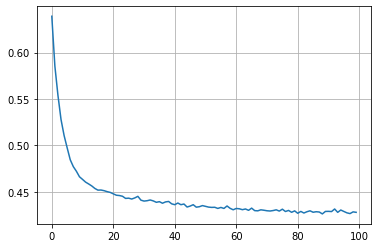

In [59]:
# Following code required for plotting figure in jupyter notebook.
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(average_loss_list)
plt.grid()
plt.show()